In [ ]:
## Step 1: Remove any broken Spark installation and reinstall
rm -rf spark-3.5.0-bin-hadoop3* spark.tgz  # Remove broken files
wget -O spark.tgz https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz  # Download again

## Verify download size
ls -lh spark.tgz  # Ensure file is 300+ MB

## Extract Spark
tar -xvf spark.tgz

## Install findspark
pip install -q findspark

## Step 2: Set Up Environment Variables
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

findspark.init("/content/spark-3.5.0-bin-hadoop3")

## Step 3: Initialize Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    appName("Colab-Spark").\
    getOrCreate()

print("Apache Spark is set up and ready!")
print("Spark Version:", spark.version)

--2025-04-24 17:11:43--  https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark.tgz’

spark.tgz           100%[===================>] 381.85M  1.41MB/s    in 3m 8s   

2025-04-24 17:14:52 (2.03 MB/s) - ‘spark.tgz’ saved [400395283/400395283]

-rw-r--r-- 1 root root 382M Sep  9  2023 spark.tgz
spark-3.5.0-bin-hadoop3/
spark-3.5.0-bin-hadoop3/kubernetes/
spark-3.5.0-bin-hadoop3/kubernetes/tests/
spark-3.5.0-bin-hadoop3/kubernetes/tests/pyfiles.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/autoscale.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/python_executable_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/worker_memory_chec

In [ ]:
from pyspark.sql.functions import col

In [ ]:
import kagglehub
import os

# for root, dirs, files in os.walk("/root/.cache/kagglehub"):
    # for name in files:
        # print(os.path.join(root, name))



# Download latest version
path = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")

# print("Path to dataset files:", path)
# # Move the files to a more accessible location
mkdir -p /content/tmdb_data
cp /root/.cache/kagglehub/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/versions/551/TMDB_movie_dataset_v11.csv /content/tmdb_data/


# Verify the move
ls /content/tmdb_data


100%|██████████| 214M/214M [00:01<00:00, 134MB/s]

Extracting files...


TMDB_movie_dataset_v11.csv


In [ ]:
ls

sample_data  spark-3.5.0-bin-hadoop3  spark.tgz  tmdb_data


In [9]:
# Load the dataset into a Spark DataFrame (assuming the CSV is inside the folder)
df = spark.read.csv("tmdb_data/TMDB_movie_dataset_v11.csv", header=True, inferSchema=True)

# Show the schema and first 5 rows
df.printSchema()
df.show(5)
# df.describe().show()


root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullab

In [10]:
from pyspark.sql.functions import col, sum

# Check for missing (null) values in each column
missing_values = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

missing_values.show()


+---+-----+------------+----------+------+------------+-------+-------+-----+-------------+------+--------+-------+-----------------+--------------+--------+----------+-----------+-------+------+--------------------+--------------------+----------------+--------+
| id|title|vote_average|vote_count|status|release_date|revenue|runtime|adult|backdrop_path|budget|homepage|imdb_id|original_language|original_title|overview|popularity|poster_path|tagline|genres|production_companies|production_countries|spoken_languages|keywords|
+---+-----+------------+----------+------+------------+-------+-------+-----+-------------+------+--------+-------+-----------------+--------------+--------+----------+-----------+-------+------+--------------------+--------------------+----------------+--------+
|  0|   13|           0|         0|     0|      219898|     28|      0|    5|       896365|    81| 1085436| 592034|              123|            40|  255843|        19|     382069| 998182|494372|             

## **Our Goals**

1-Revenue prediction is critical for financial decision-making in the movie industry.

2-Movie recommendations can directly impact user engagement and platform retention.

3-Identifying patterns around genre and budget efficiency helps optimize movie production and marketing.

In [11]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, LongType, DoubleType
# Filter out rows where 'revenue' is 0 or null
df = df.filter((df['revenue'] > 0) & df['revenue'].isNotNull())

# List of columns to convert (this includes columns with numeric data)
columns_to_convert = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'revenue']

# Convert all relevant columns to their appropriate types (DoubleType for numeric columns)
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast('double'))

# Verify the schema to ensure the conversion was successful
df.printSchema()

# Now, find the numeric columns
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, LongType, DoubleType)) and field.name != 'id']


# Print the length of the numeric_columns list
print("Length of numeric_columns:", len(numeric_columns))
print("Numeric columns:", numeric_columns)

# Calculate correlation with 'revenue'
correlations = []
for col_name in numeric_columns:
    correlation_value = df.stat.corr('revenue', col_name)
    correlations.append((col_name, correlation_value))

# Show the correlations
for col_name, corr_value in correlations:
    print(f"Correlation between revenue and {col_name}: {corr_value}")


root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: double (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: double (nullable = true)
 |-- runtime: double (nullable = true)
 |-- adult: string (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullab

📊 Training Data Metrics:
  RMSE: 79449055.49 (lower is better)
  MAE: 26438683.14 (lower is better)
  R2: 0.5598 (closer to 1 is better)

📊 Validation Data Metrics:
  RMSE: 78036678.39
  MAE: 25677465.36
  R2: 0.5754

📊 Test Data Metrics:
  RMSE: 61680329.71
  MAE: 23505173.45
  R2: 0.6802

📌 Feature coefficients (importance):
  vote_average: -1444299.2082209338
  vote_count: 25819.50032691836
  runtime: -36763.954390879415
  budget: 1.4607885662661808
  popularity: 110280.36099363369
+--------------------+-------------+--------------------+
|            features|      revenue|          prediction|
+--------------------+-------------+--------------------+
|[8.477,25409.0,14...| 6.77387716E8| 7.386708713930466E8|
|[7.346,14868.0,15...|1.065659812E9| 6.770560577630346E8|
|[7.6,7677.0,129.0...| 1.68841459E8| 2.381244891971637E8|
|[7.584,1171.0,112...|  6.4803131E7|2.6320369401179746E7|
|[7.124,6692.0,111...| 2.42875078E8|2.3181767894003502E8|
+--------------------+-------------+----------

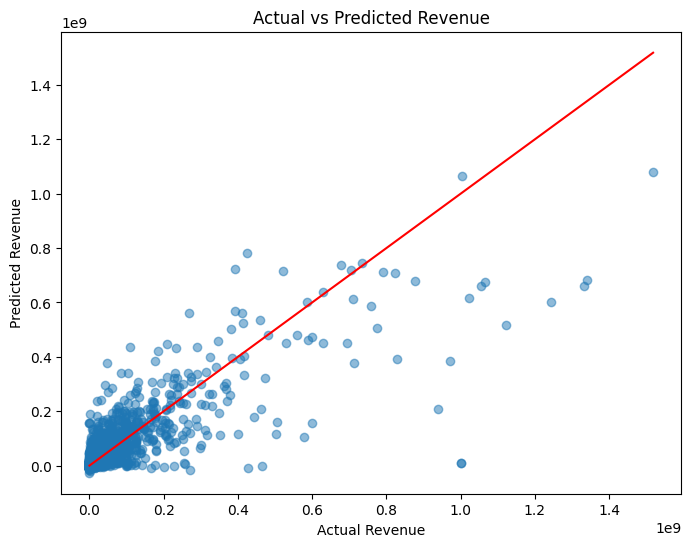

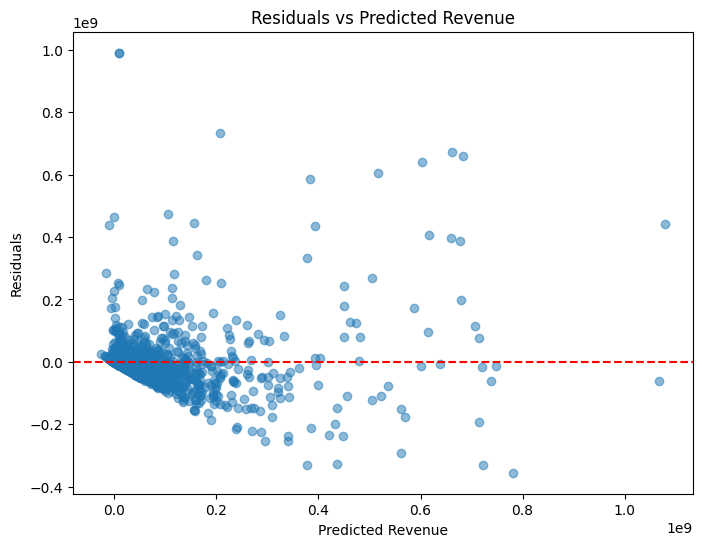

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare the data
features = ['vote_average', 'vote_count', 'runtime', 'budget', 'popularity']
df_clean = df.dropna(subset=['revenue'] + features)
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_transformed = assembler.transform(df_clean)

# Step 2: Split the data (70% train, 15% validation, 15% test)
train_data, valid_data, test_data = df_transformed.randomSplit([0.7, 0.15, 0.15], seed=1234)

# Step 3: Initialize and train the model
lr = LinearRegression(featuresCol='features', labelCol='revenue')
lr_model = lr.fit(train_data)

# Step 4: Evaluate model accuracy on all sets
train_results = lr_model.evaluate(train_data)
valid_results = lr_model.evaluate(valid_data)
test_results = lr_model.evaluate(test_data)

print("📊 Training Data Metrics:")
print(f"  RMSE: {train_results.rootMeanSquaredError:.2f} (lower is better)")
print(f"  MAE: {train_results.meanAbsoluteError:.2f} (lower is better)")
print(f"  R2: {train_results.r2:.4f} (closer to 1 is better)\n")

print("📊 Validation Data Metrics:")
print(f"  RMSE: {valid_results.rootMeanSquaredError:.2f}")
print(f"  MAE: {valid_results.meanAbsoluteError:.2f}")
print(f"  R2: {valid_results.r2:.4f}\n")

print("📊 Test Data Metrics:")
print(f"  RMSE: {test_results.rootMeanSquaredError:.2f}")
print(f"  MAE: {test_results.meanAbsoluteError:.2f}")
print(f"  R2: {test_results.r2:.4f}")

# Step 5: Feature coefficients
print("\n📌 Feature coefficients (importance):")
for feature, coeff in zip(features, lr_model.coefficients):
    print(f"  {feature}: {coeff}")

# Step 6: Predictions
predictions = lr_model.transform(test_data)
predictions.select("features", "revenue", "prediction").show(5)

# Step 7: Plot Actual vs Predicted Revenue
pd_predictions = predictions.select("revenue", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(pd_predictions['revenue'], pd_predictions['prediction'], alpha=0.5)
plt.plot([pd_predictions['revenue'].min(), pd_predictions['revenue'].max()],
         [pd_predictions['revenue'].min(), pd_predictions['revenue'].max()], color='red')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.show()

# Step 8: Plot Residuals
pd_predictions['residual'] = pd_predictions['revenue'] - pd_predictions['prediction']
plt.figure(figsize=(8,6))
plt.scatter(pd_predictions['prediction'], pd_predictions['residual'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Revenue")
plt.show()
